In [1]:
from __future__ import annotations
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from collections.abc import Callable
from queue import PriorityQueue
from io import StringIO
import seaborn as sns
from dataclasses import dataclass, field
from typing import Any
import bisect
pd.set_option("display.max_colwidth", 0)
# from IPython.core.display import display, HTML
# display(HTML("<style>div.output_scroll { height: 100em; }</style>"))


In [2]:
raw_data = pd.read_csv("play_sessions.csv")

In [3]:
len(raw_data)

967

In [4]:
raw_data = raw_data[raw_data.user_id.notnull()]
raw_data = raw_data[raw_data.version == "1.0.3"]
raw_data = raw_data.reset_index()
len(raw_data)

619

![diagram](diagram.png)

In [5]:
class Episode():
    def __init__(self):
        self.passing = False
        self.programming_interface = pd.DataFrame()
        self.episode_data = pd.DataFrame()
        self.program = ""
        self.challenge_name = ""
    def __init__(self, pi:pd.DataFrame, ed:pd.DataFrame, passing:bool, program_rep:str, challenge_name:str):
        self.passing = passing
        self.programming_interface = pi
        self.episode_data = ed
        self.program = program_rep
        self.challenge_name = challenge_name
    def __str__(self):
        return str(ed)
        

In [6]:
def parse_raw_data_frames(row:int) -> pd.DataFrame:
    frames = raw_data.frames[row]
    obj = json.loads(frames)
    for i, o in enumerate(obj):
        obj[i] = json.loads(obj[i])
    session = pd.DataFrame(obj)
    return session

memo_frames = {}

def iter_session_frames():
    for i in raw_data.index:
        if i not in memo_frames:   
            frames = parse_raw_data_frames(i)
            memo_frames[i] = frames
        yield memo_frames[i].copy()

def iter_enum_session_frames(): #TODO: uh make this not a weird copy
    for i in raw_data.index:
        yield i, parse_raw_data_frames(i)

In [7]:
organized_sessions = defaultdict(list)
other_actors = pd.DataFrame()

for i, all_frames in iter_enum_session_frames():
    if len(all_frames) == 0:
        continue
    user_id = raw_data.user_id[i]
    
    episode_list = []
    passing = False
    state = ""
    challenge_name = ""
    curr_prog_interface = ""
    prev_prog_interface = ""
    curr_episode_data = ""
    frame_header = all_frames.columns.to_series().to_frame(1).T.to_csv(index=False).partition("\n")[0]

    for i, frame in all_frames.iterrows():
        if frame.actor == "episode_data":
            if frame.object_name == "challenge_pass":
                passing = True
            if frame.verb == "episode_started":
                challenge_name = frame.object_name
                episode_list.append(Episode(
                    passing=passing, 
                    pi=pd.DataFrame(StringIO(f'{frame_header}\n{prev_prog_interface}')), 
                    ed=pd.DataFrame(StringIO(f'{frame_header}\n{curr_episode_data}')), 
                    program_rep=state, challenge_name=challenge_name))
                state = json.dumps(json.loads(frame.state_info["program"]), sort_keys=True)
                passing = False
                prev_prog_interface = curr_prog_interface
                curr_prog_interface = ""
                curr_episode_data = ""
                
            curr_episode_data = f'{curr_episode_data}{frame.to_frame(1).T.to_csv(header=False, index=False)}'
        elif frame.actor == "programming_interface":
            curr_prog_interface = f'{curr_prog_interface}{frame.to_frame(1).T.to_csv(header=False, index=False)}'
        else:
            other_actors = pd.concat([other_actors, frame.to_frame(1).T],  ignore_index=True, sort=True)
    # record last episode and last program changes
    episode_list.append(Episode(
        passing=passing, 
        pi=pd.DataFrame(StringIO(prev_prog_interface)), 
        ed=pd.DataFrame(StringIO(curr_episode_data)), 
        program_rep=state, challenge_name=challenge_name))
    if len(curr_prog_interface) > 0:
        episode_list.append(Episode(
            passing=False, 
            pi=pd.DataFrame(StringIO(curr_prog_interface)), 
            ed=pd.DataFrame(columns=all_frames.columns), 
            program_rep="", challenge_name=challenge_name))
        
    organized_sessions[user_id].append(episode_list)
    

In [8]:
del raw_data

In [9]:
heatmap_ratio = pd.DataFrame() # rows are user id, columns are session, values are episode pass rate
heatmap_tries = pd.DataFrame()
# TODO: assumption is that user runs each challenge once

for user_id, sessions_list in organized_sessions.items():
    for i, session in enumerate(sessions_list):
        if len(session) > 0:
            challenge = session[0].challenge_name
        else:
            challenge = "no episodes"
        num_unique_starts = 0
        num_unique_passes = 0
        for j, episode in enumerate(session):
            if episode.program != "":
                if num_unique_starts == 0:
                    num_unique_starts += 1
                    if episode.passing:
                        num_unique_passes += 1
                else:
                    if episode.program != session[j-1].program:
                        num_unique_starts += 1
                        if episode.passing:
                            num_unique_passes += 1
        if num_unique_starts != 0:
            heatmap_ratio.loc[user_id,challenge] = num_unique_passes / num_unique_starts
            
        else:
            heatmap_ratio.loc[user_id,challenge] = -1
        heatmap_tries.loc[user_id,challenge] = num_unique_starts


In [10]:
# heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
heatmap_ratio

,spike_curric_turning_in_place_curriculum,spike_curric_turning_in_place_left_turn_try_it,spike_curric_90_degree_turn_try_it,,spike_curric_advertising_challenge,spike_curric_adjust_pixel_brightness_try_it,spike_curric_write_your_own_message_try_it,spike_curric_smile_mini_challenge,spike_curric_sound_commands_curriculum,spike_curric_sequential_tones,...,spike_curric_move_until_hard_pressed_try_it,spike_curric_move_until_pressed_starting_point_try_it,spike_curric_arm_wait_until_try_it,spike_curric_vacuum_mini_challenge,spike_curric_exploring_a_disaster_site_challenge,spike_curric_light_commands_curriculum,spike_curric_programing_a_sequence,spike_curric_other_turns_with_steering_curriculum,spike_curric_wait_until_near_change_threshold_try_it,spike_curric_getting_started_curriculum
1923583.0,1.0,1.0,1.000000,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927377.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947069.0,0.5,1.0,0.500000,-1.0,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,1.000,1.0,0.500000,0.00,NaN,NaN,NaN,NaN,NaN
1927379.0,0.0,1.0,1.000000,-1.0,NaN,0.5,0.5,1.0,0.0,0.5,...,0.0,0.875,1.0,0.000000,0.00,1.0,1.0,1.0,1.0,NaN
1947080.0,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1947078.0,1.0,1.0,1.000000,-1.0,0.5,1.0,1.0,1.0,1.0,1.0,...,0.0,1.000,0.0,1.000000,0.00,1.0,1.0,0.5,1.0,NaN
1947084.0,0.5,1.0,1.000000,-1.0,0.5,1.0,0.5,NaN,1.0,1.0,...,0.0,1.000,0.5,0.000000,0.00,1.0,0.0,1.0,1.0,NaN
1927404.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947087.0,1.0,1.0,1.000000,-1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.5,NaN,NaN
1947124.0,NaN,1.0,1.000000,-1.0,0.0,1.0,1.0,1.0,0.5,NaN,...,0.0,NaN,1.0,0.000000,1.00,NaN,1.0,1.0,NaN,NaN


Text(158.22222222222223, 0.5, 'user id')

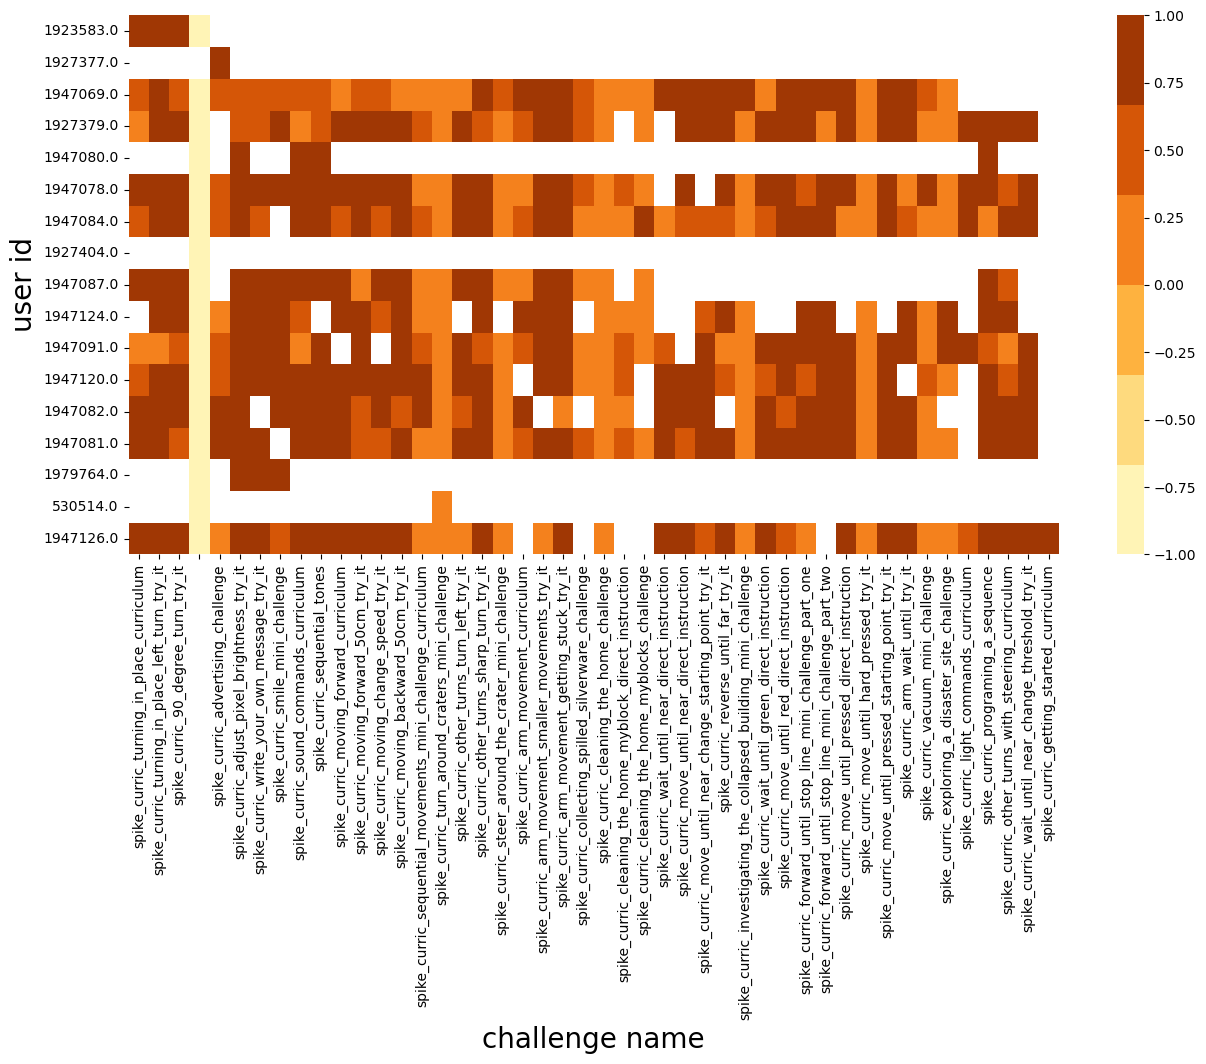

In [11]:
plt.figure(figsize=(15,7))
p = sns.heatmap(heatmap_ratio,
           cmap=sns.color_palette("YlOrBr"))
p.set_xlabel("challenge name", fontsize = 20)
p.set_ylabel("user id", fontsize = 20)

Text(158.22222222222223, 0.5, 'user id')

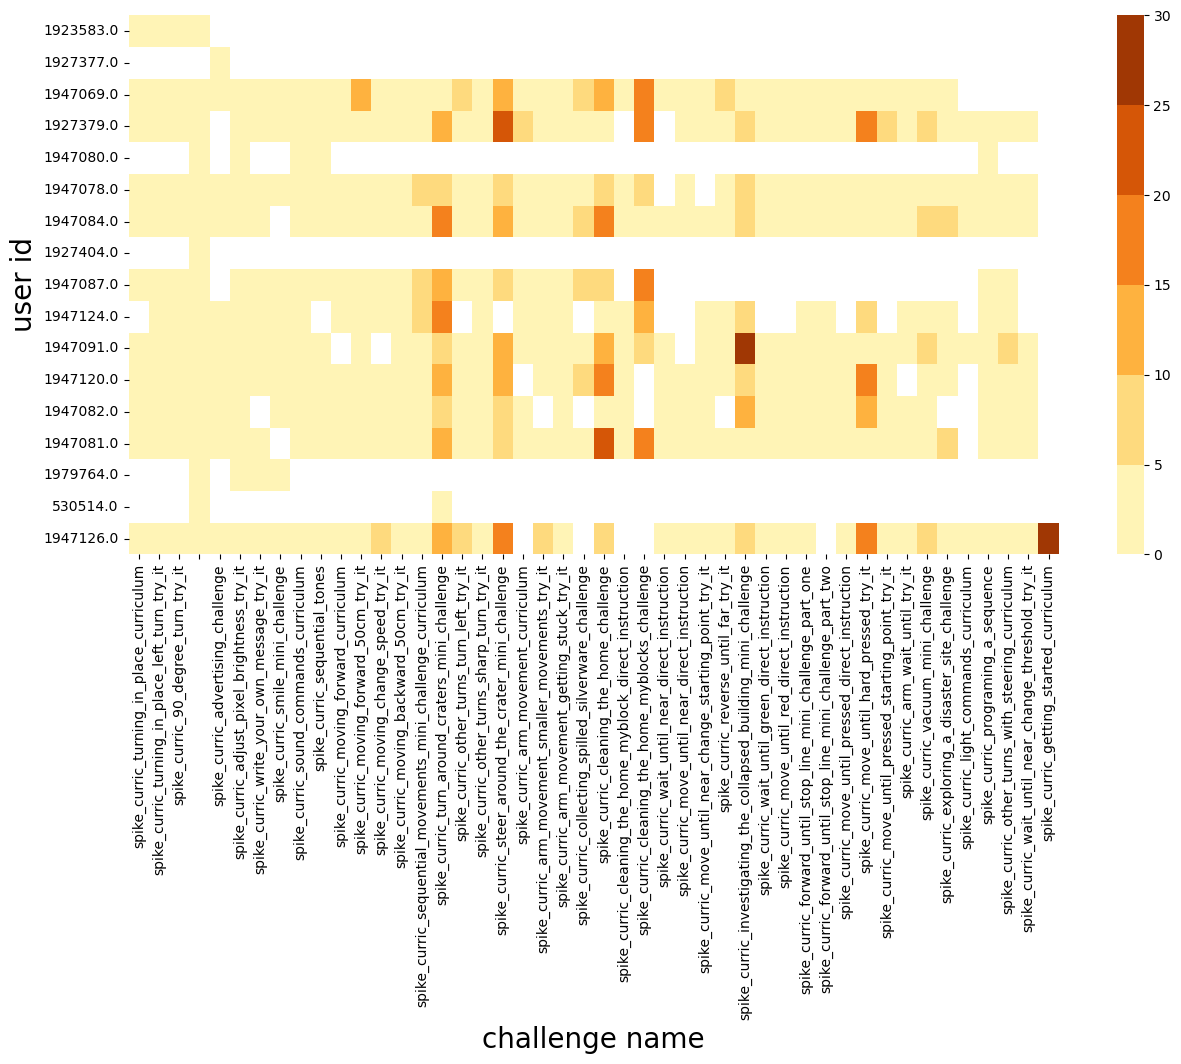

In [12]:
plt.figure(figsize=(15,7))
p = sns.heatmap(heatmap_tries,
           cmap=sns.color_palette("YlOrBr"))
p.set_xlabel("challenge name", fontsize = 20)
p.set_ylabel("user id", fontsize = 20)

Text(170.72222222222223, 0.5, 'user id')

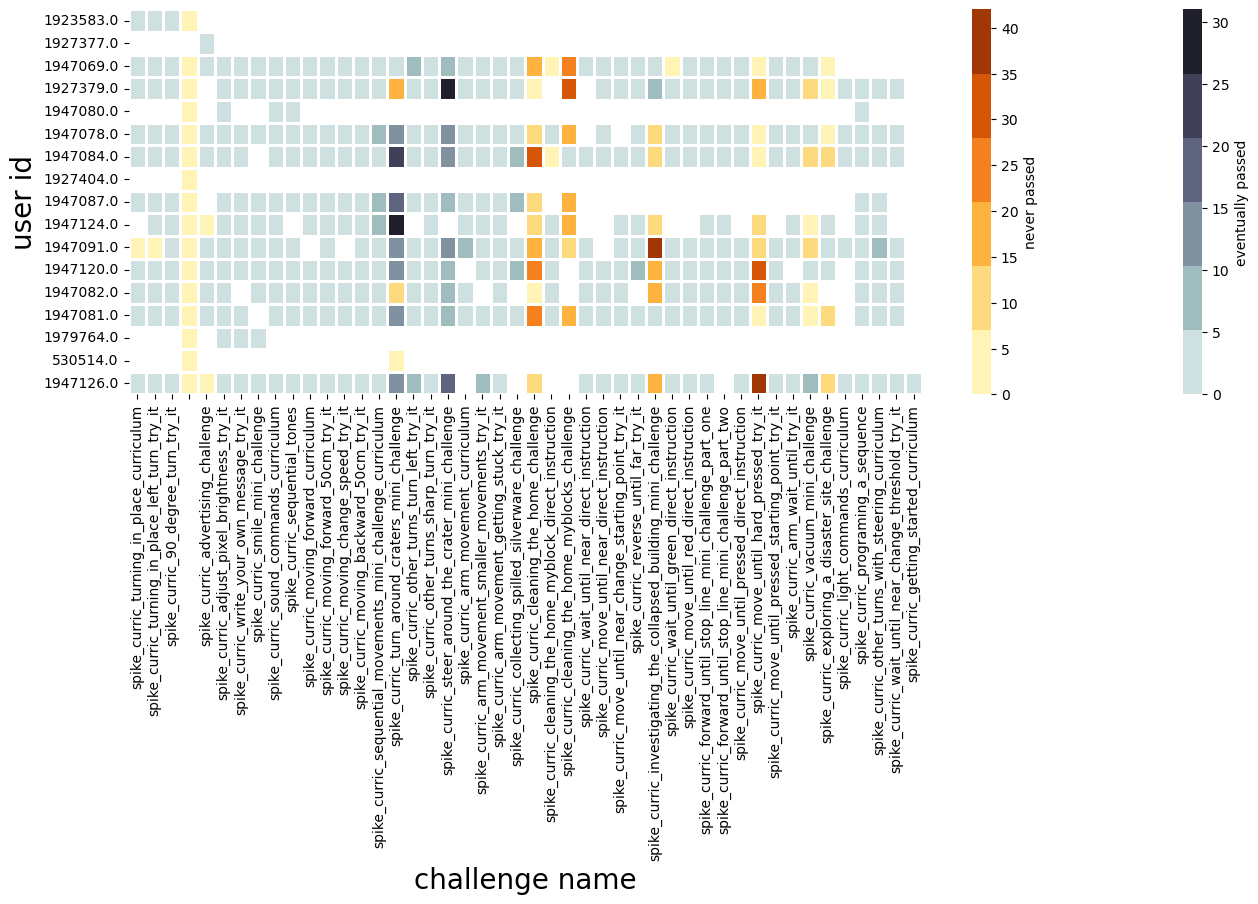

In [13]:
# for each challenge, how many attempts before the passing attempt?

def failing_attempt_counter(list_of_episodes) -> (int, bool):
    counter = 0
    for episode in list_of_episodes:
        if episode.passing:
            return counter, True
        else:
            counter += 1
    return counter, False

heatmap_failing_tries = pd.DataFrame() # rows are user id, columns are session, values are episode pass rate
heatmap_eventually_passed = pd.DataFrame()

for user_id, sessions_list in organized_sessions.items():
    for i, session in enumerate(sessions_list):
        if len(session) > 0:
            challenge = session[0].challenge_name
        else:
            challenge = "no episodes"

        numattempts, passed = failing_attempt_counter(session)
        heatmap_failing_tries.loc[user_id,challenge] = numattempts
        heatmap_eventually_passed.loc[user_id,challenge] = passed
        
heatmap_eventually_passed[:] = heatmap_eventually_passed[:].astype(bool)
plt.figure(figsize=(16,5))
p = sns.heatmap(heatmap_failing_tries, cbar_kws={'label': "eventually passed"},
           cmap=sns.color_palette("bone_r"), vmin=0, linewidths=1, mask=~heatmap_eventually_passed)#, annot=True)
p = sns.heatmap(heatmap_failing_tries, cbar_kws={'label': "never passed"},
           cmap=sns.color_palette("YlOrBr"), vmin=0, linewidths=1, mask=heatmap_eventually_passed)#, annot=True)
p.set_xlabel("challenge name", fontsize = 20)
p.set_ylabel("user id", fontsize = 20)

# for user_id, sessions_list in organized_sessions.items():
#     fig, ax = plt.subplots(1, len(sessions_list), sharey=True)
#     for i, session in enumerate(sessions_list):
#         if len(session) > 0:
#             challenge_name = session[0].challenge_name
#         else:
#             challenge_name = ""
#         ax[i].title.set_text(challenge_name)
        
#         ax[i].histogram([failing_attempt_counter(session)])

In [14]:
def find_session(userid:int, challengename:str) -> list:
    for session in reversed(organized_sessions[userid]):
        if len(session) > 0 and session[0].challenge_name == challengename:
            return session
    return []

In [15]:
sesh = find_session(1927379, "spike_curric_turn_around_craters_mini_challenge")
json.loads(sesh[1].program)['targets'][0]['blocks']['!QNn08d3nL#%E%[LEByz'].keys()

dict_keys(['fields', 'inputs', 'next', 'opcode', 'parent', 'shadow', 'topLevel'])

In [16]:
def print_program_changes_over_time(userid:int, challengename:str):
    prev_ops = []
    prev_inputs = []
    prev_fields = []
    for episode in find_session(userid, challengename):
        if len(episode.program) > 0:
            blocks = json.loads(episode.program)['targets'][0]['blocks']
            ops = [bi['opcode'] for bid, bi in blocks.items()]
            inps = [str(bi['inputs']) for bid, bi in blocks.items()]
            fields = [str(bi['fields']) for bid, bi in blocks.items()]
            print(Counter(ops) - Counter(prev_ops))
            print(Counter(inps) - Counter(prev_inputs))
            print(Counter(fields) - Counter(prev_fields))
            prev_ops = ops
            prev_inputs = inps
            prev_fields = fields
            print("------------")

In [17]:
print_program_changes_over_time(1927379, "spike_curric_turn_around_craters_mini_challenge")

Counter({'spike_movement_direction_picker': 8, 'spike_movemenet_direction_for_duration': 8, 'spike_movement_moveHeadingForUnits': 6, 'spike_heading_input': 6, 'event_whenprogramstarts': 2})
Counter({'{}': 16, "{'HEADING': [1, 'w{LV=`MU]6(%a2ExP@Fy'], 'RATE': [1, [4, '35']]}": 1, "{'DIRECTION': [1, '%IBmZLo#/*,.u]eQfd!@'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, ',j}lMPXq9/ffO:D9pImu'], 'RATE': [1, [4, '20']]}": 1, "{'DIRECTION': [1, '=s9Sw[qd07jCOz9ZWPZW'], 'RATE': [1, [4, '8']]}": 1, "{'HEADING': [1, 'z%,Jez_H-yw^FRKt}yx1'], 'RATE': [1, [4, '70']]}": 1, "{'DIRECTION': [1, 'RPnWybW}.=lWhplJF~^V'], 'RATE': [1, [4, '35']]}": 1, "{'DIRECTION': [1, 'I$J/@Z#oG3phLss$gGYd'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, 'jzcJ^nFfaf;zXk6pLgBe'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, 's/LO|]yg16!_44Dy6;$J'], 'RATE': [1, [4, '8']]}": 1, "{'HEADING': [1, '9dj5OfSk_Hp]u*lwRN!t'], 'RATE': [1, [4, '30']]}": 1, "{'DIRECTION': [1, 'G;IQ@,t1mp#{ypVsseu`'], 'RATE': [1, [4, '8']]}": 1, 

In [18]:
print_program_changes_over_time(1947078, "spike_curric_turn_around_craters_mini_challenge")

Counter({'spike_movement_direction_picker': 13, 'spike_movemenet_direction_for_duration': 13, 'event_whenprogramstarts': 1})
Counter({'{}': 14, "{'DIRECTION': [1, '[S],vr[)RV@n)`WqY;~/'], 'RATE': [1, [4, '10']]}": 1, "{'DIRECTION': [1, '7.Zf82+,doumwl^^QF/v'], 'RATE': [1, [4, '10']]}": 1, "{'DIRECTION': [1, 'f/_JWud!(c2}brRx#e,M'], 'RATE': [1, [4, '10']]}": 1, "{'DIRECTION': [1, 'y9jH@[^Y=7)dN;^GP-kv'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, 'bR%!q6R/Nbd!CBu%+[lR'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, 'iLb#5l!PTA,_o2?bq4-n'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, 'OCc=QtZb`1Sl([@Sv.%.'], 'RATE': [1, [4, '10']]}": 1, "{'DIRECTION': [1, 'Jof;NZ!s(+o#3(5Toomv'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, '!-ii=0/L[M39PmD]mm~u'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, '=hN1kU!3s[=wJA/EOf_z'], 'RATE': [1, [4, '10']]}": 1, "{'DIRECTION': [1, ',HE_2~J}Ug*Kie,r9.B-'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, 'N_:*DDy6OF*Oi?CFx3I5'], 'RATE': [1, [4,

In [19]:
print_program_changes_over_time(1947069, "spike_curric_turn_around_craters_mini_challenge")

Counter({'spike_movement_direction_picker': 13, 'spike_movemenet_direction_for_duration': 13, 'spike_movement_setMovementSpeed': 1, 'spike_light_turnOnForSeconds': 1, 'event_whenprogramstarts': 1})
Counter({'{}': 14, "{'DIRECTION': [1, '!}K._Y~yxo%`|Z^Fc Q6'], 'RATE': [1, [4, '4']]}": 1, "{'DIRECTION': [1, ':nw5NKcilWH6z{Z2wmIC'], 'RATE': [1, [4, '30']]}": 1, "{'SPEED': [1, [4, '30']]}": 1, "{'DIRECTION': [1, 'Y5mJQ)IDv.gb_ptRS[b{'], 'RATE': [1, [4, '80']]}": 1, "{'DIRECTION': [1, 'P,keGR42}I8iIt|Aq(DH'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, '%Dw;3gKLOn`X[mxCPiAM'], 'RATE': [1, [4, '5']]}": 1, "{'DIRECTION': [1, '(wg?R5:?,udLWal9NJ`^'], 'RATE': [1, [4, '30']]}": 1, "{'RATE': [1, [5, '2']]}": 1, "{'DIRECTION': [1, 'GB|h@KSowsS1[Pa(#*2*'], 'RATE': [1, [4, '70']]}": 1, "{'DIRECTION': [1, '1y-7p!,bvY,=3TjQZ5u_'], 'RATE': [1, [4, '8']]}": 1, "{'DIRECTION': [1, '@$m?-I}nWJ4vzu*v1xA8'], 'RATE': [1, [4, '6']]}": 1, "{'DIRECTION': [1, '/:8;V!L3=tXj8dPBep%)'], 'RATE': [1, [4, '4']]}": 

def equal_ignore_order(a, b):
    """ Use only when elements are neither hashable nor sortable! """
    unmatched = list(b)
    for element in a:
        try:
            unmatched.remove(element)
        except ValueError:
            return False
    return not unmatched
# AST

In [19]:
# codes
from enum import Enum

OpCodes = Enum('OpCodes', ["spike_movemenet_direction_for_duration",
    "spike_movemenet_direction",
    "spike_movement_moveHeadingForUnits",
    "spike_movement_startMoving",
    "spike_movement_stopMoving",
    "spike_movement_moveHeadingForUnitAtSpeed",
    "spike_movement_moveForUnitsAtSpeeds",
    "spike_movement_setMovementSpeed",
    "spike_movement_startMovingHeadingAtSpeed",
    "spike_movement_startMovingAtSpeeds",
    "spike_motor_runForDirectionTimes",
    "spike_motor_runDirection",
    "spike_motor_stopMotor",
    "spike_motor_position",
    "spike_light_turnOnForSeconds",
    "spike_set_pixel_brightness",
    "spike_write",
    "spike_sensor_is_pressed",
    "spike_sensor_force",
    "spike_sensor_is_distance",
    "spike_sensor_distance",
    "spike_sensor_reflected_light_intensity",
    "spike_sensor_is_reflected_light",
    "spike_sensor_is_color",
    "spike_sensor_color",
    "spike_sensor_reset_yaw",
    "spike_sensor_angle",
    "spike_sensor_is_orientation",
    "spike_sensor_is_moved",
    "spike_sensor_is_button",
    "spike_sensor_timer",
    "spike_sensor_reset_timer",
    "spike_sound_playuntildone",
    "spike_sound_startsound",
    "spike_play_beep",
    "spike_start_playing_beep",
    "spike_stop_all_sounds",
    "spike_set_volume",
    "event_whenprogramstarts",
    "spike_sensor_motor_menu",
    "spike_direction_picker",
    "spike_movement_direction_picker",
    "spike_heading_input",
    "spike_sensor_port_menu",
    "spike_sensor_color_menu"])



In [44]:
class ASTNode:
    def __init__(self):
        self.parent = None
        self.blockid = None
        self.op = None
        self.children = []
        self._height = 1
        
    def __init__(self, parent, blockid, desc, children):
        self.parent = parent
        self.blockid = blockid
        self.op = desc
        self.children = sorted(children, key=lambda n: n.blockid)
        self._height = self.__height__()
    
    def accept(self, visit_func:Callable[['ASTNode'],None]):
        visit_func(self)
        for c in self.children:
            c.accept(visit_func)
            
    def accept_postorder(self, visit_func:Callable[['ASTNode'],None]):
        for c in self.children:
            c.accept(visit_func)
        visit_func(self)
            
    def __eq__(self, other:'ASTNode'):
        if self.op != other.op:
            return False
        if len(self.children) != len(other.children):
            return False
        return self.children == other.children
    
    def __height__(self):
        if len(self.children) == 0:
            return 1
        return max([c.height() for c in self.children]) + 1
    
    def height(self):
        return self._height
    
    def count_subtree_occurences(self, other:'ASTNode'):
        if other._height > self._height:
            return 0
        if self == other:
            return 1
        counter = 0
        for c in self.children:
            counter += c.count_subtree_occurences(other)
        return counter
        
    def iter_descendants(self):
        yield self
        for c in self.children:
            yield from c.iter_descendants()
            
    def get_descendants(self):
        return [s for s in self.iter_descendants()]
    
    def __str__(self):
        return f"ASTNode: {self.blockid} {self.op}\n\tParent: {self.parent.blockid if self.parent else None}, {len(self.children)} children"
    

In [21]:
def get_max_key(pq:defaultdict)->int:
    return max(pq.keys())

def insert_pq(pq:defaultdict, n:ASTNode):
    pq[n.height()].append(n)
    
def dice(parent1:ASTNode, parent2:ASTNode, mappings: list):
    desc1 = parent1.get_descendants()
    desc2 = parent2.get_descendants()
    
    contained_mappings = [(t1, t2) for (t1, t2) in mappings \
                          if (t1 in desc1 and t2 in desc2)]
    return 2*len(contained_mappings) / (len(desc1) + len(desc2))
    

def gumtree(head1:ASTNode, head2:ASTNode):
    # top down phase
    subtree_queue1 = defaultdict(list) # dict { height : [subtrees with that height]
    subtree_queue2 = defaultdict(list)
    
    candidate_mappings = []
    mappings = []
    
    
    insert_pq(subtree_queue1, head1)
    insert_pq(subtree_queue2, head2)
    
    while len(subtree_queue1)> 0 and len(subtree_queue2) > 0:
        maxheight1 = get_max_key(subtree_queue1)
        maxheight2 = get_max_key(subtree_queue2)
        
        if maxheight1 != maxheight2:
            if maxheight1 > maxheight2:
                maxtrees = subtree_queue1[maxheight1]
                del subtree_queue1[maxheight1]
                for t in maxtrees:
                    for c in t.children:
                        insert_pq(subtree_queue1, c)
            else:
                maxtrees = subtree_queue2[maxheight2]
                del subtree_queue2[maxheight2]
                for t in maxtrees:
                    for c in t.children:
                        insert_pq(subtree_queue2, c)
        else:
            maxtrees1 = subtree_queue1[maxheight1]
            maxtrees2 = subtree_queue2[maxheight2]
            added_trees1 = []
            added_trees2 = []
            for t1 in maxtrees1:
                for t2 in maxtrees2:
                    if t1 == t2:
                        if head1.count_subtree_occurences(t2) > 1 or \
                        head2.count_subtree_occurences(t1) > 1:
                            candidate_mappings.append((t1, t2))
                        else:
                            mappings.append((t1, t2))
                        added_trees1.append(t1)
                        added_trees2.append(t2)
            for t in maxtrees1:
                if t not in added_trees1:
                    for c in t.children:
                        insert_pq(subtree_queue1, c)
            for t in maxtrees2:
                if t not in added_trees2:
                    for c in t.children:
                        insert_pq(subtree_queue2, c)
    sorted_candidates = sorted(candidate_mappings, 
                               key = lambda t1, t2: dice(t1.parent, t2.parent, mappings),
                               reverse=True)
    while len(sorted_candidates) > 0:
        top = sorted_candidates[0]
        del sorted_candidates[0]
        mappings.append(top)
        sorted_candidates = [s for s in sorted_candidates \
                             if s[0]!=top[0] and s[1] != top[1]]
    
    # bottom up
    matched1 = [t[0] for t in mappings]
    matched2 = [t[1] for t in mappings]
    def bottom_up_helper(node:ASTNode):
        if node not in matched1:
            mapped_child = False
            for c in node.children:
                if c in matched1:
                    mapped_child = True
                    break
            if mapped_child:
                candidates = []
                head2.accept(lambda n : 
                             n.op == node.op and n.blockid == node.blockid and n not in matched2 and candidates.append(n))
                candidates = sorted(candidates,
                                    key = lambda t2: dice(node, t2, mappings),
                                    reverse=True)
                if len(candidates) > 0 and dice(node, candidates[0], mappings) > 0.45:
                    mappings.append(node, candidates[0])
                    # here the original gumtree algorithm uses an edit script algorithm to find 
                    # further mappings for trees under a certain size, but all these programs are small
                    # so I don't anticipate needing that
    node1.accept_postorder(bottom_up_helper)
    return mappings

In [43]:
def build_ast_tree(program_blocks:dict):
    root_node = None
    nodes = {} # block id: node
    for blockid, block in program_blocks.items():
        parent_id = block["parent"]
#         desc = block["opcode"]
#         if OpCodes[desc] >= 0:
#             desc = OpCodes[desc]
        desc = OpCodes[block["opcode"]]
        child_id = block["next"]
        
        node = ASTNode(None, blockid, desc, [])
        
        if parent_id in nodes:
            node.parent = nodes[parent_id]
            nodes[parent_id].children.append(node)
            
        if child_id in nodes:
            node.children.append(nodes[child_id])
        
        for k, v in block["fields"].items():
            id_num = blockid+"_field_"+str(k)
            field_node = ASTNode(None, id_num, k, [])
            field_child_node = ASTNode(field_node, id_num+"_value", v, [])
            field_node.children.append(field_child_node)
            node.children.append(field_node)
            
        for k, v in block["inputs"].items():
            id_num = blockid+"_input_"+str(k)
            input_node = ASTNode(None, id_num, k, [])
            input_child_node = ASTNode(input_node, id_num+"_value", v, [])
            input_node.children.append(input_child_node)
            node.children.append(input_node)
    
        nodes[blockid] = node
        
        if block["topLevel"] and desc == OpCodes.event_whenprogramstarts:
            root_node = node
    return root_node

def edit_script(mappings, root1, root2):
    removed = []
    added = []
    mappings1 = [m[0] for m in mappings]
    mappings2 = [m[1] for m in mappings]
    
    def find_unmapped_nodes(map_list:list, results:list, node:ASTNode):
        if node not in map_list:
            results.append(node)
    
    def find_removed_nodes(n):
        find_unmapped_nodes(mappings1, removed, n)
    
    def find_added_nodes(n):
        find_unmapped_nodes(mappings2, added, n)
    
    return removed, added

def print_edit_script(removed, added):
    print("Removed:")
    for node in removed:
        print(node)
    print("Added")
    for node in added:
        print(node)
    

def print_ast_changes_over_time(userid:int, challengename:str):
    prev_episode = None
    for episode in find_session(userid, challengename):
        if len(episode.program) > 0:
            blocks = json.loads(episode.program)['targets'][0]['blocks']
            
#             print(blocks)
            root = build_ast_tree(blocks)
#             print(root)
            if prev_episode is not None:
                mappings = gumtree(prev_episode, root)
                print(edit_script(mappings, prev_episode, root))
            prev_episode = root
            print("------------")

In [23]:
# possible indicators of struggling/good performing

In [24]:
import signal
from contextlib import contextmanager


@contextmanager
def timeout(time):
    # Register a function to raise a TimeoutError on the signal.
    signal.signal(signal.SIGALRM, raise_timeout)
    # Schedule the signal to be sent after ``time``.
    signal.alarm(time)

    try:
        yield
    except TimeoutError:
        pass
    finally:
        # Unregister the signal so it won't be triggered
        # if the timeout is not reached.
        signal.signal(signal.SIGALRM, signal.SIG_IGN)


def raise_timeout(signum, frame):
    raise TimeoutError

In [45]:
%%prun -s cumulative -q -l 10 -T prun0
with timeout(500):
    print_ast_changes_over_time(1927379, "spike_curric_turn_around_craters_mini_challenge")

------------
 
*** Profile printout saved to text file 'prun0'. 


In [26]:
# print_ast_changes_over_time(1927379, "spike_curric_turn_around_craters_mini_challenge")

In [27]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

/tmp/ipykernel_9717/158162212.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


[('curr_episode_data', 2414719),
 ('other_actors', 1408318),
 ('prev_prog_interface', 83351),
 ('state', 13338),
 ('heatmap_failing_tries', 6964),
 ('heatmap_ratio', 6964),
 ('heatmap_tries', 6964),
 ('frame', 2014),
 ('heatmap_eventually_passed', 1490),
 ('ASTNode', 1064),
 ('Counter', 1064),
 ('Episode', 1064),
 ('PriorityQueue', 1064),
 ('Callable', 896),
 ('organized_sessions', 648),
 ('sessions_list', 472),
 ('StringIO', 408),
 ('defaultdict', 408),
 ('sesh', 248),
 ('frame_header', 144),
 ('build_ast_tree', 136),
 ('contextmanager', 136),
 ('dataclass', 136),
 ('dice', 136),
 ('edit_script', 136),
 ('failing_attempt_counter', 136),
 ('field', 136),
 ('find_session', 136),
 ('get_max_key', 136),
 ('gumtree', 136),
 ('insert_pq', 136),
 ('iter_enum_session_frames', 136),
 ('iter_session_frames', 136),
 ('parse_raw_data_frames', 136),
 ('print_ast_changes_over_time', 136),
 ('print_edit_script', 136),
 ('print_program_changes_over_time', 136),
 ('raise_timeout', 136),
 ('timeout', 1

In [28]:
%load_ext memory_profiler


ModuleNotFoundError: No module named 'memory_profiler'

In [ ]:
from episodes_vs_programs import test, print_ast_changes_over_time
%mprun -T mprof0 -f print_ast_changes_over_time test()